In [ ]:
!pip install yfinance pandas numpy scikit-learn transformers newsapi-python ta torch

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from newsapi import NewsApiClient
from ta.momentum import RSIIndicator
import torch
from datetime import timedelta
from google.colab import userdata
import matplotlib.pyplot as plt
import os
# Set the environment variable to be the value stored in user secrets.
os.environ['NEWS_API_KEY'] = userdata.get('NEWS_API_KEY')
print("All packages imported successfully!")

All packages imported successfully!


[*********************100%***********************]  1 of 1 completed

<class 'newsapi.newsapi_client.NewsApiClient'>



Device set to use cuda:0


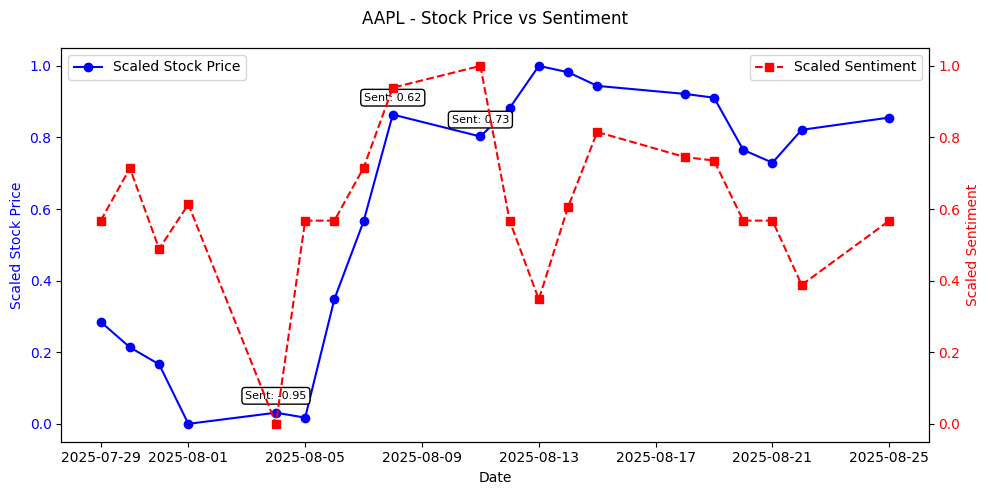

Correlation between returns and sentiment: 0.010


In [ ]:
def fetch_stock_data(symbol, period="5d", interval="1h"):
    """Fetch stock data from Yahoo Finance with RSI."""
    stock_data = yf.download(symbol, period=period, interval=interval, auto_adjust=True)
    if stock_data.empty:
        print(f"No stock data found for {symbol}")
        return pd.DataFrame(columns=['Date', 'Close', 'RSI'])

    stock_data = stock_data.reset_index()
    # Flatten columns if they are MultiIndex
    stock_data.columns = stock_data.columns.get_level_values(0)

    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    close_series = stock_data['Close'].squeeze()
    stock_data['RSI'] = RSIIndicator(close_series).rsi().squeeze()

    return stock_data[['Date', 'Close', 'RSI']]

def fetch_news_sentiment_batch(newsapi, symbol, start_date, end_date):
    """Fetch news and compute sentiment in batch using FinBERT."""
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    from datetime import timedelta

    articles = newsapi.get_everything(
        q=symbol,
        from_param=start_date.strftime('%Y-%m-%d'),
        to=end_date.strftime('%Y-%m-%d'),
        language='en',
        sort_by='relevancy',
        page_size=50
    )["articles"]

    # Prepare texts and dates
    texts, dates = [], []
    for article in articles:
        title = article["title"] or ""
        description = article.get("description", "") or ""
        text = f"{title} {description}".strip()
        if not text:
            continue
        published_time = pd.to_datetime(article["publishedAt"])
        date = published_time.date()
        if published_time.hour >= 16:
            date += timedelta(days=1)
        texts.append(text)
        dates.append(date)

    if not texts:
        return pd.DataFrame(columns=['date_shifted', 'polarity'])

    # Initialize FinBERT pipeline
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, batch_size=16, device=0)

    # Batch predict
    results = sentiment_analyzer(texts)

    # Map results to polarity
    polarities = []
    for r in results:
        polarity = 1 if r['label'] == 'positive' else -1 if r['label'] == 'negative' else 0
        polarity *= r['score']
        polarities.append(polarity)

    df = pd.DataFrame({"date": dates, "polarity": polarities})
    daily_sentiment = df.groupby("date")["polarity"].mean().reset_index()
    daily_sentiment["date_shifted"] = pd.to_datetime(daily_sentiment["date"]) + timedelta(days=1)
    daily_sentiment.columns = daily_sentiment.columns.get_level_values(0)
    return daily_sentiment[['date_shifted', 'polarity']]

def plot_stock_vs_sentiment(stock_data, daily_sentiment, symbol):
    """Plot stock price vs sentiment with normalized scales."""
    # Build full date range
    date_range = pd.date_range(
        start=stock_data["Date"].min(),
        end=stock_data["Date"].max(),
        freq="D"
    )

    # Reindex sentiment to cover every stock date
    daily_sentiment = (
        daily_sentiment
        .set_index("date_shifted")
        .reindex(date_range, fill_value=0)
        .reset_index()
        .rename(columns={"index": "date_shifted"})
    )

    # 🔧 Ensure columns are flat (avoid multiindex merge errors)
    daily_sentiment.columns = daily_sentiment.columns.get_level_values(0)

    # Merge on dates
    merged_df = pd.merge(
        stock_data[["Date", "Close"]],
        daily_sentiment[["date_shifted", "polarity"]],
        left_on="Date",
        right_on="date_shifted",
        how="left"
    )
    merged_df["polarity"] = merged_df["polarity"].fillna(0)

    if merged_df.empty:
        print("Merged DataFrame is empty. Check date alignment.")
        print(f"Stock dates: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
        print(f"Sentiment dates: {daily_sentiment['date_shifted'].min()} to {daily_sentiment['date_shifted'].max()}")
        return

    # Normalize stock price and sentiment
    scaler = MinMaxScaler()
    merged_df["Close_scaled"] = scaler.fit_transform(merged_df[["Close"]])
    merged_df["polarity_scaled"] = scaler.fit_transform(merged_df[["polarity"]])

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(
        merged_df["Date"], merged_df["Close_scaled"],
        color="blue", marker="o", label="Scaled Stock Price"
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Scaled Stock Price", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.plot(
        merged_df["Date"], merged_df["polarity_scaled"],
        color="red", marker="s", linestyle="--", label="Scaled Sentiment"
    )
    ax2.set_ylabel("Scaled Sentiment", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Annotate strong sentiment points
    for _, row in merged_df.iterrows():
        if abs(row["polarity"]) > 0.5:
            ax1.annotate(
                f"Sent: {row['polarity']:.2f}",
                (row["Date"], row["Close_scaled"]),
                textcoords="offset points", xytext=(0, 10), ha="center", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
            )

    fig.suptitle(f"{symbol} - Stock Price vs Sentiment")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # Correlation between daily returns and sentiment
    merged_df["Returns"] = merged_df["Close"].pct_change()
    correlation = merged_df[["Returns", "polarity"]].corr().iloc[0, 1]
    print(f"Correlation between returns and sentiment: {correlation:.3f}")

# Main execution
stock_symbol = "AAPL"
newsapi = NewsApiClient(api_key='getyourownapikey')  # Use Colab Secrets
print(type(newsapi))

stock_data = fetch_stock_data(stock_symbol)
daily_sentiment = fetch_news_sentiment(newsapi, stock_symbol, stock_data["Date"].min(), stock_data["Date"].max())
plot_stock_vs_sentiment(stock_data, daily_sentiment, stock_symbol)